In [ ]:
import openreview
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
import numpy as np
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/akgoldbe/opt/anaconda3/envs/analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
client = openreview.api.OpenReviewClient(
    baseurl='https://api2.openreview.net',
)
# get all submissions to NeurIPS 2024
VENUE_ID = 'NeurIPS.cc/2024/Conference'
venue_group = client.get_group(f'{VENUE_ID}')
submission_name = venue_group.content['submission_name']['value']
submissions = client.get_all_notes(invitation=f'{VENUE_ID}/-/{submission_name}', details='directReplies')

Getting V2 Notes: 100%|█████████▉| 4231/4236 [00:08<00:00, 491.59it/s]


In [36]:
all_reviews = []
for paper in submissions:
    id = paper.id
    title = paper.content['title']['value']
    primary_area = paper.content['primary_area']['value']
    keywords = paper.content['keywords']['value']
    reviews = []
    decision = None 
    for reply in paper.details['directReplies']:
        if any('Official_Review' in s for s in reply['invitations']):
            rating = reply['content']['rating']['value']
            soundness = reply['content']['soundness']['value']
            presentation = reply['content']['presentation']['value']
            contribution = reply['content']['contribution']['value']
            confidence = reply['content']['confidence']['value']
            reviewer_id = reply['signatures'][0].split('/')[-1]
            review_number = reply['number']
            reviews.append({
                'paper_id': id,
                'title': title,
                'primary_area': primary_area,
                'keywords': keywords,
                'reviewer_id': reviewer_id,
                'rating': rating,
                'soundness': soundness,
                'presentation': presentation,
                'contribution': contribution,
                'confidence': confidence,
                'review_number': review_number
            })
        if any('Decision' in s for s in reply['invitations']):
            if decision is None:
                decision = reply['content']['decision']['value']
    for review in reviews:
        review['decision'] = decision
    all_reviews.extend(reviews)


In [37]:
df = pd.DataFrame(all_reviews)


In [ ]:
df.head()

,paper_id,title,primary_area,keywords,reviewer_id,rating,soundness,presentation,contribution,confidence,review_number,decision
0,zzOOqD6R1b,Stress-Testing Capability Elicitation With Pas...,safety_in_machine_learning,"[LLMs, Elicitation, Fine-tuning, Sandbagging, ...",Reviewer_Y88j,8,4,4,3,4,1,Accept (poster)
1,zzOOqD6R1b,Stress-Testing Capability Elicitation With Pas...,safety_in_machine_learning,"[LLMs, Elicitation, Fine-tuning, Sandbagging, ...",Reviewer_VH7G,7,3,3,3,3,2,Accept (poster)
2,zzOOqD6R1b,Stress-Testing Capability Elicitation With Pas...,safety_in_machine_learning,"[LLMs, Elicitation, Fine-tuning, Sandbagging, ...",Reviewer_JNQU,5,3,3,3,3,3,Accept (poster)
3,zzOOqD6R1b,Stress-Testing Capability Elicitation With Pas...,safety_in_machine_learning,"[LLMs, Elicitation, Fine-tuning, Sandbagging, ...",Reviewer_Vgeo,5,3,4,2,4,4,Accept (poster)
4,zxSWIdyW3A,Cooperative Hardware-Prompt Learning for Snaps...,machine_vision,"[snapshot compressive imaging, hyperpectral im...",Reviewer_aeby,5,2,2,2,3,1,Accept (poster)


In [ ]:
# save as csv
df.to_csv('neurips2024_reviews.csv')

### Generate Intervals (Min + Max Score) ###

In [ ]:
df = df[df.decision != 'Reject'].reset_index(drop=True)

In [ ]:
df.groupby('paper_id').max().value_counts('decision')

decision
Accept (poster)       3648
Accept (spotlight)     326
Accept (oral)           61
Name: count, dtype: int64

In [ ]:
ratings = df.groupby('paper_id').agg({'rating': ['max', 'mean', 'min', 'count'], 'decision': 'max'}).reset_index()
ratings.columns = ['paper_id', 'rating_max', 'rating_mean', 'rating_min', 'num_reviews', 'decision']
# rename Accept (poster) to Poster and Accept (oral) or Accept (spotlight) to Spotlight/Oral
ratings['decision'] = ratings['decision'].replace({'Accept (poster)': 'Poster', 'Accept (oral)': 'Spotlight/Oral', 'Accept (spotlight)': 'Spotlight/Oral'})
ratings['decision'].value_counts()

decision
Poster            3648
Spotlight/Oral     387
Name: count, dtype: int64

In [ ]:
# subsample ratings by 25% stratifying by decision for plotting
ratings_sample = ratings.groupby('decision', group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42)
).reset_index(drop=True)


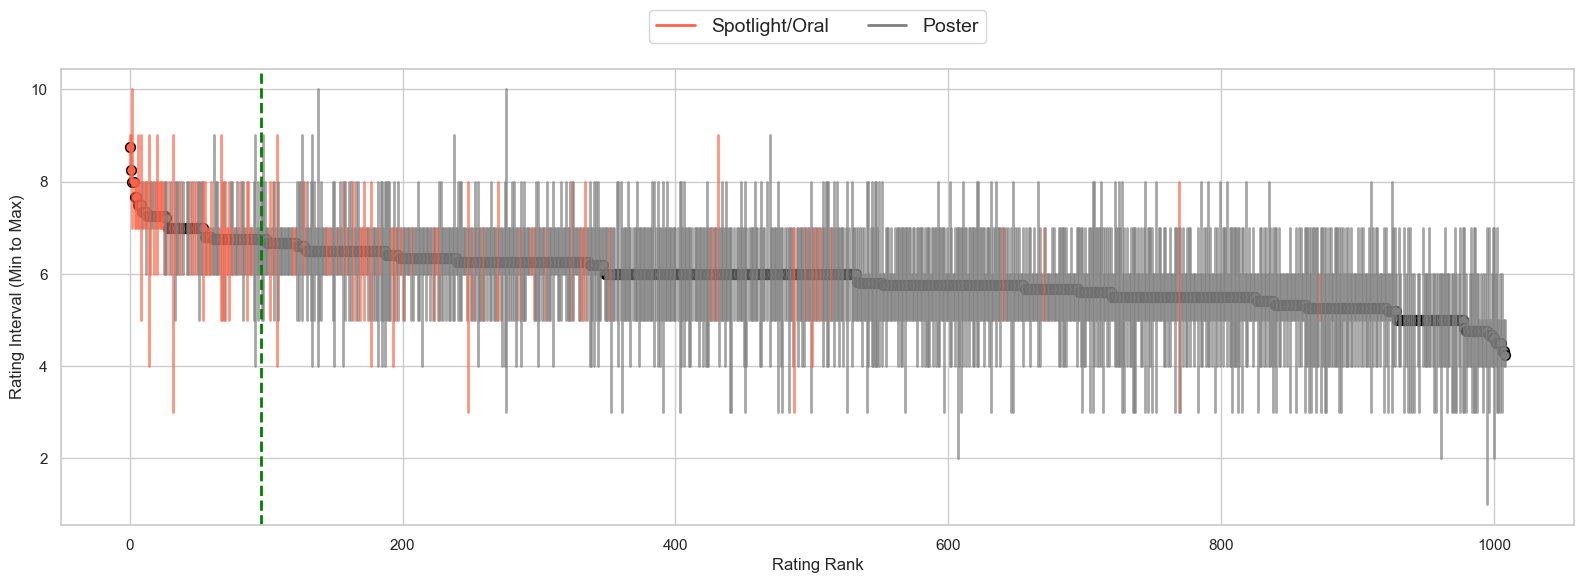

In [ ]:
# Set the style
sns.set(style="whitegrid")
# Set the color palette
sns.set_palette("husl")
# Define colors for each decision type
decision_colors = {
    'Spotlight/Oral': '#FF6347',  # Tomato
    'Poster': '#808080',          # Gray
}

# Plot
fig, ax = plt.subplots(figsize=(16, 6))  # Increased width from 12 to 16
for idx, row in ratings_sample.iterrows():
    color = decision_colors[row['decision']]
    ax.plot([idx, idx], [row['rating_min'], row['rating_max']], color=color, alpha=0.7, lw=2)
    ax.scatter(idx, row['rating_mean'], color=color, edgecolor='black', s=50, label=row['decision'] if row['decision'] not in ax.get_legend_handles_labels()[1] else "")

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=decision) for decision, color in decision_colors.items()]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=2)

# Add vline at cutoff between # of posters and spotlights 
ax.axvline(x=ratings_sample[ratings_sample['decision'] == 'Spotlight/Oral'].shape[0] - 0.5, color='green', linestyle='--', lw=2, label='Poster/Spotlight Cutoff')

# Add labels and title
ax.set_ylabel("Rating Interval (Min to Max)")
ax.set_xlabel("Rating Rank")

plt.tight_layout()
plt.show()


### Generate Intervals (Leave One Out Intervals)

In [ ]:
ratings = df.groupby('paper_id').agg({'rating': list, 'decision': 'max'}).reset_index()

In [ ]:
def get_interval(lst):
    means = []
    for i in range(len(lst)):
        temp_lst = lst[:i] + lst[i+1:]
        mean = 1. * sum(temp_lst) / len(temp_lst)
        means.append(mean)
    return min(means), max(means)

In [ ]:
intervals = ratings['rating'].apply(get_interval)

In [ ]:
ratings['rating_min'] = intervals.apply(lambda x: x[0])
ratings['rating_max'] = intervals.apply(lambda x: x[1])
ratings['rating_mean'] = ratings['rating'].apply(lambda x: sum(x) / len(x))

In [ ]:
ratings

,paper_id,rating,decision,lower,upper,mean,rating_min,rating_max,rating_mean
0,00uVk06eVK,"[7, 7, 5]",Poster,6.000000,7.000000,6.333333,6.000000,7.000000,6.333333
1,01XV5Za56k,"[7, 7, 6, 5]",Poster,6.000000,6.666667,6.250000,6.000000,6.666667,6.250000
2,01qa1ZJs65,"[5, 4, 5, 7]",Poster,4.666667,5.666667,5.250000,4.666667,5.666667,5.250000
3,01s5ODIHKd,"[6, 6, 4, 6]",Poster,5.333333,6.000000,5.500000,5.333333,6.000000,5.500000
4,02CIZ8qeDc,"[5, 6, 7]",Poster,5.500000,6.500000,6.000000,5.500000,6.500000,6.000000
...,...,...,...,...,...,...,...,...,...
4030,zv4UISZzp5,"[7, 4, 4]",Poster,4.000000,5.500000,5.000000,4.000000,5.500000,5.000000
4031,zv9gYC3xgF,"[6, 6, 6, 6]",Poster,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
4032,zw2K6LfFI9,"[6, 6, 7, 6]",Poster,6.000000,6.333333,6.250000,6.000000,6.333333,6.250000
4033,zxSWIdyW3A,"[5, 5, 6, 6]",Poster,5.333333,5.666667,5.500000,5.333333,5.666667,5.500000


In [ ]:
ratings['decision'] = ratings['decision'].replace({'Accept (poster)': 'Poster', 'Accept (oral)': 'Spotlight/Oral', 'Accept (spotlight)': 'Spotlight/Oral'})

In [ ]:
# subsample ratings by 25% stratifying by decision for plotting
ratings_sample = ratings.groupby('decision', group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42)
).reset_index(drop=True)


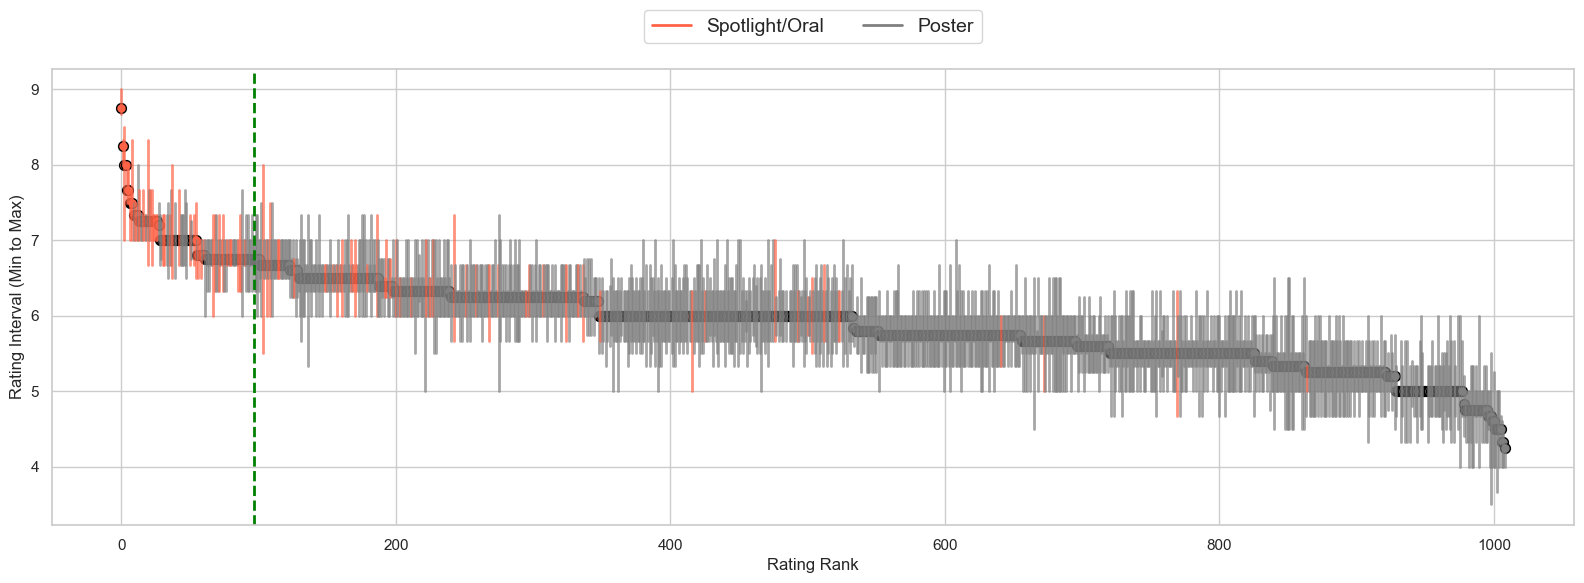

In [ ]:
# order ratings by mean
ratings_sample = ratings_sample.sort_values('rating_mean', ascending=False).reset_index(drop=True)

# Set the color palette
sns.set_palette("husl")
# Define colors for each decision type
decision_colors = {
    'Spotlight/Oral': '#FF6347',  # Tomato
    'Poster': '#808080',          # Gray
}

# Plot
fig, ax = plt.subplots(figsize=(16, 6))  # Increased width from 12 to 16
for idx, row in ratings_sample.iterrows():
    color = decision_colors[row['decision']]
    ax.plot([idx, idx], [row['rating_min'], row['rating_max']], color=color, alpha=0.7, lw=2)
    ax.scatter(idx, row['rating_mean'], color=color, edgecolor='black', s=50, label=row['decision'] if row['decision'] not in ax.get_legend_handles_labels()[1] else "")

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=decision) for decision, color in decision_colors.items()]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=2)

# Add vline at cutoff between # of posters and spotlights 
ax.axvline(x=ratings_sample[ratings_sample['decision'] == 'Spotlight/Oral'].shape[0] - 0.5, color='green', linestyle='--', lw=2, label='Poster/Spotlight Cutoff')

# Add labels and title
ax.set_ylabel("Rating Interval (Min to Max)")
ax.set_xlabel("Rating Rank")

plt.tight_layout()
plt.show()

## Generate Intervals from Bayesian Gaussian Model

In [42]:
df = df[df.decision != 'Reject'].reset_index(drop=True)
ratings = df.groupby('paper_id').agg({'rating': list, 'decision': 'max'}).reset_index()
# rename Accept (poster) to Poster and Accept (oral) or Accept (spotlight) to Spotlight/Oral
ratings['decision'] = ratings['decision'].replace({'Accept (poster)': 'Poster', 'Accept (oral)': 'Spotlight/Oral', 'Accept (spotlight)': 'Spotlight/Oral'})

In [74]:
def get_interval(data, 
                draws: int = 1000, 
                tune: int = 1000, 
                seed: int = 42):
    """
    Fit:
        θ ~ Normal(0, 2.0)
        τ ~ Gamma(1.0, 1.0)
        x_j | θ, τ ~ Normal(θ, 1/√τ)
    
    and return the (lower, upper) bounds of a CI_width credible interval for θ.
    """
    # ensure our observed data is float
    data = np.asarray(data, dtype=np.float32)
    
    def model(obs=None):
        # Prior for mean θ
        theta = numpyro.sample("theta", dist.Normal(0.0, 2.0))
        
        # Prior for precision τ
        tau = numpyro.sample("tau", dist.Gamma(1.0, 1.0))
        
        # Convert precision to standard deviation for Normal
        sigma = 1.0 / jnp.sqrt(tau)
        
        # Likelihood
        with numpyro.plate("obs", len(obs) if obs is not None else 0):
            numpyro.sample("x", dist.Normal(theta, sigma), obs=obs)
    
    # Setup the sampler
    rng_key = random.PRNGKey(seed)
    nuts_kernel = NUTS(model)
    mcmc = MCMC(
        nuts_kernel,
        num_warmup=tune,
        num_samples=draws,
        num_chains=1
    )
    
    # Run the inference
    mcmc.run(rng_key, obs=data)
    
    # Get samples and compute the credible interval
    samples = mcmc.get_samples()
    theta_samples = samples["theta"]
    
    # Calculate credible interval bounds
    lower50 = np.percentile(theta_samples, 25)
    upper50 = np.percentile(theta_samples, 75)
    lower95 = np.percentile(theta_samples, 92.5)
    upper95 = np.percentile(theta_samples, 97.5)
    x = np.mean(theta_samples)
    
    return x, lower50, upper50, lower95, upper95

In [75]:
samples = ratings['rating'].apply(get_interval)

sample: 100%|██████████| 2000/2000 [00:02<00:00, 766.62it/s, 7 steps of size 5.12e-01. acc. prob=0.88] 


In [76]:
ratings['theta_mean'] = [samples[0] for samples in samples]
ratings['theta_lower50'] = [samples[1] for samples in samples]
ratings['theta_upper50'] = [samples[2] for samples in samples]
ratings['theta_lower95'] = [samples[3] for samples in samples]
ratings['theta_upper95'] = [samples[4] for samples in samples]

In [82]:
ratings.to_csv('neurips2024_gaussian_intervals.csv')

In [78]:
# subsample ratings by 25% stratifying by decision for plotting
ratings_sample = ratings.groupby('decision', group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42)
).reset_index(drop=True)

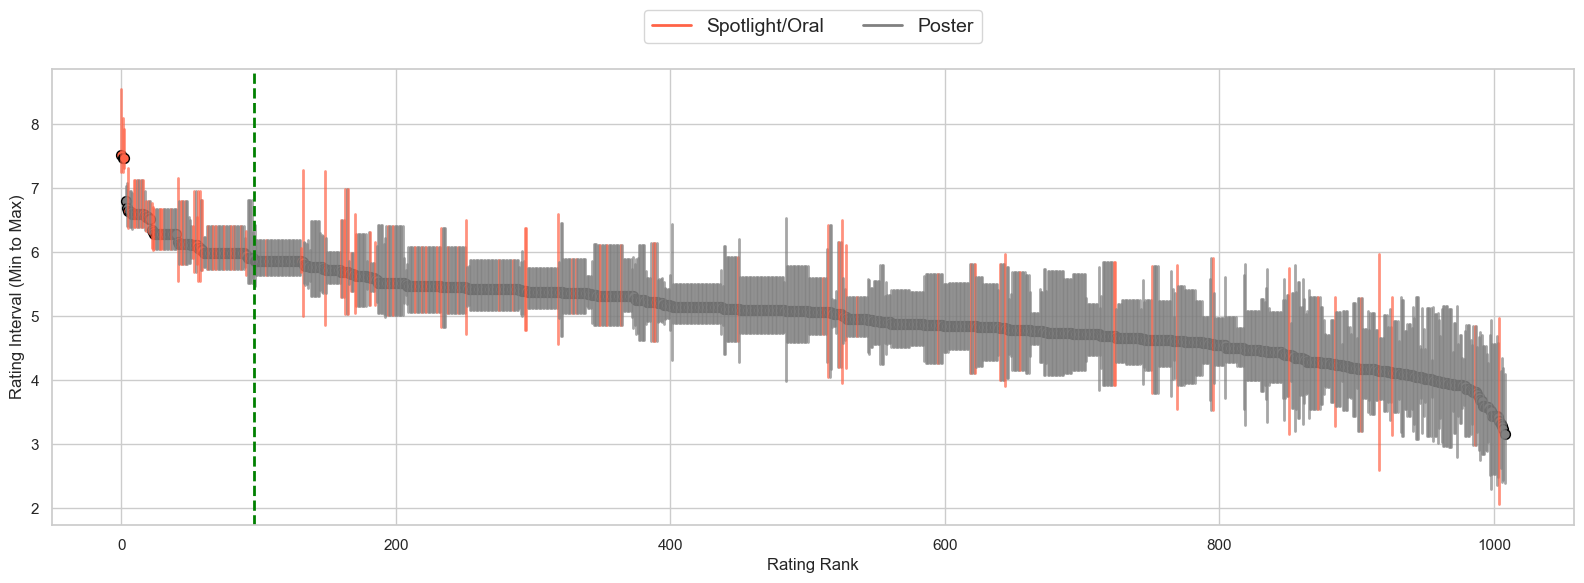

In [79]:
# order ratings by mean
ratings_sample = ratings_sample.sort_values('theta_mean', ascending=False).reset_index(drop=True)

# Set the style
sns.set(style="whitegrid")
# Set the color palette
sns.set_palette("husl")
# Define colors for each decision type
decision_colors = {
    'Spotlight/Oral': '#FF6347',  # Tomato
    'Poster': '#808080',          # Gray
}

# Plot
fig, ax = plt.subplots(figsize=(16, 6))  # Increased width from 12 to 16
for idx, row in ratings_sample.iterrows():
    color = decision_colors[row['decision']]
    ax.plot([idx, idx], [row['theta_lower50'], row['theta_upper50']], color=color, alpha=0.7, lw=2)
    ax.scatter(idx, row['theta_mean'], color=color, edgecolor='black', s=50, label=row['decision'] if row['decision'] not in ax.get_legend_handles_labels()[1] else "")

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=decision) for decision, color in decision_colors.items()]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=2)

# Add vline at cutoff between # of posters and spotlights 
ax.axvline(x=ratings_sample[ratings_sample['decision'] == 'Spotlight/Oral'].shape[0] - 0.5, color='green', linestyle='--', lw=2, label='Poster/Spotlight Cutoff')

# Add labels and title
ax.set_ylabel("Rating Interval (Min to Max)")
ax.set_xlabel("Rating Rank")

plt.tight_layout()
plt.show()